In [1]:
# Package Imports
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib
import matplotlib.pyplot as plt

from shapely.geometry import MultiLineString, LineString, Polygon, Point
from shapely import wkt
from shapely.affinity import rotate, scale

import rasterio
import rasterio.features
import rasterio.warp
from rasterio.plot import show

import pulp

from spopt.locate.coverage import LSCP
from spopt.locate import PMedian

from importlib import reload

# to load the interactive plotting version
#matplotlib widget
# or regular
%matplotlib inline

# Importing my modules
import data_loading, set_cover, plotting, geometry_operations, optimization_functions

##### Reading the data and generate map

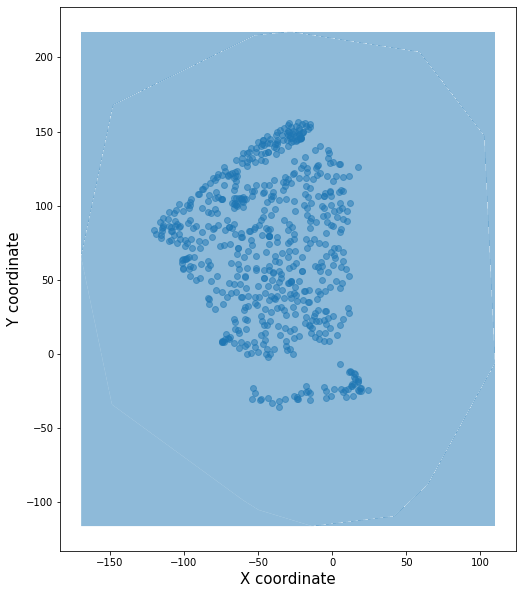

In [2]:
# read TIF and CSV data
forest_area_gdf, bestand_3_csv = data_loading.load_bestand_and_forest()

# add trees to the map
point_list = [Point(xy) for xy in zip(bestand_3_csv["x"], bestand_3_csv["y"])]
tree_gdf = gpd.GeoDataFrame(data=bestand_3_csv,geometry=point_list)

#verify that the boundary and trees add up
plotting.plot_gdfs([tree_gdf, forest_area_gdf])

#### Joining and Overlaying Anchor Areas and Road on the Map

##### Recording coordinates with interactive figure

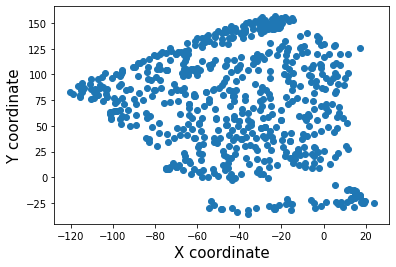

In [3]:
coords = []
fig, ax = plt.subplots()
ax.set_xlabel('X coordinate', fontsize=15)
ax.set_ylabel('Y coordinate', fontsize=15)
ax.scatter(tree_gdf["x"],tree_gdf["y"])

cid = fig.canvas.mpl_connect('button_press_event',  lambda event: plotting.onclick(event,coords))

In [4]:
# disconnect the interactive figure so it doesnt eat up resources
fig.canvas.mpl_disconnect(cid)

##### Creating extra_geometry_gpd from manual coordinates

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


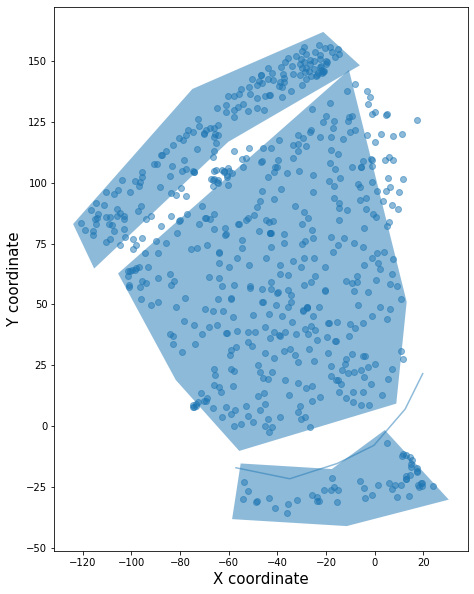

In [5]:
# manually insert those coordinates
# recorded coordinates for the given areas
downhill_anchors = Polygon([Point(xy) for xy in [(-123.88268627035482, 83.05479790035122), (-74.89307684787903, 138.5299549848453), (-21.10056454084676, 161.97821725767267), (-6.051468835903222, 148.2524051955298), (-60.16417466857257, 116.79741921978575), (-115.23746107815322, 64.75371515082742)]])
uphill_anchors = Polygon([Point(xy) for xy in [(-55.04107825837903, -15.31352187833928), (-17.578435758838708, -17.601157222029755), (4.194723984483858, -1.5877098161964227), (30.450593086725803, -30.18315161232738), (-11.49475877173387, -41.04941949485714), (-58.5632070403871, -38.189875315244045)]])
road = LineString([(-57.282432937838706, -17.029248386107135), (-34.86888614324194, -21.604519073488092), (-15.337081079379033, -15.31352187833928), (-0.2879853744354932, -7.878707011345227), (12.51975565104837, 6.990922722642864), (19.884206740701615, 21.86055245663097)])
inner_forest = Polygon([Point(xy) for xy in [(-105.43005197808363, 62.73802056488026), (-10.557896233758669, 146.34023494632802), (13.160142702322588, 51.07259530235265), (8.890895693827957, 9.27148811162877), (-55.62217021231302, -10.17088732591722), (-81.71201304200238, 18.992675830401765)]])

extra_geometry_gpd = gpd.GeoDataFrame(pd.DataFrame({"name":["uphill_anchors","road","downhill_anchors","inner_forest"],"geometry":[uphill_anchors,road,downhill_anchors,inner_forest]}))

# set the name as index to easily select the geometry
extra_geometry_gpd.set_index("name", inplace = True)
extra_geometry_gpd.loc['road']

plotting.plot_gdfs([tree_gdf,extra_geometry_gpd])

#### Generating Eligible Trees and Road Pathway

Getting the points along the road

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/geometry_operations.py:66: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  road_points = [road_geometry.interpolate(distance) for distance in distances] + [road_geometry.boundary[1]]


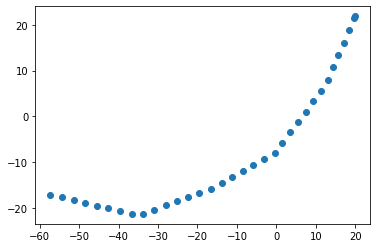

In [6]:
interval = 3
road_points = geometry_operations.generate_road_points(extra_geometry_gpd.loc['road'].geometry, interval)
plotting.plot_scatter_xy(road_points)

Getting the trees contained in the anchor/target tree polygons

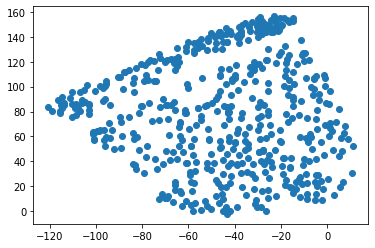

In [7]:
# get the eligible anchor and target trees inside the polygon
anchor_trees_gdf = geometry_operations.filter_gdf_by_contained_elements(tree_gdf, extra_geometry_gpd.loc["uphill_anchors"].geometry)
target_trees_gdf = geometry_operations.filter_gdf_by_contained_elements(tree_gdf,extra_geometry_gpd.loc["downhill_anchors"].geometry)
inner_forest_gdf = geometry_operations.filter_gdf_by_contained_elements(tree_gdf, extra_geometry_gpd.loc["inner_forest"].geometry)
harvesteable_trees_gdf = pd.concat([target_trees_gdf,inner_forest_gdf])

# and check if the anchor trees look good
plotting.plot_scatter_xy(harvesteable_trees_gdf.geometry)

#### Generating Possible Lines

##### Setting and rotating the slope line

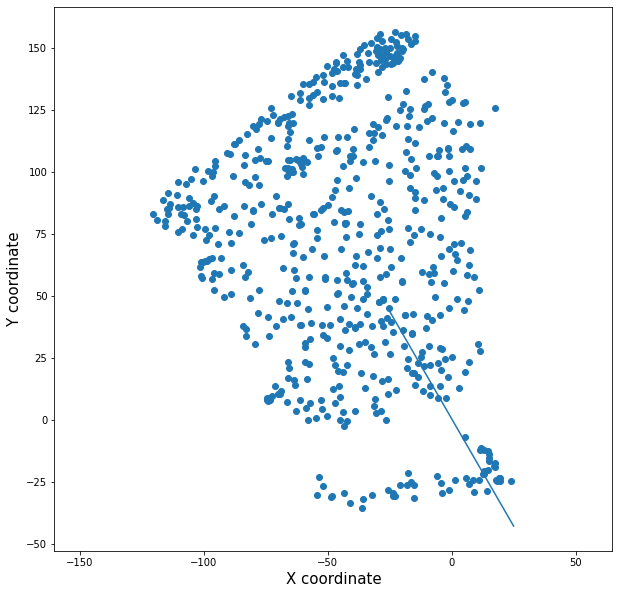

In [8]:
slope_degree = 30

# set a orientation line we can plan the line deviation around
slope_line = LineString([(0,0),(0,1)])
slope_line = rotate(slope_line, slope_degree)

# scale the line by a factor of 100 and plot it
slope_line = scale(slope_line,100,100)

ax = plotting.plot_equal_axis(slope_line)
ax.scatter(bestand_3_csv["x"], bestand_3_csv["y"])

##### Constraining lines to those with suitable anchor trees

<AxesSubplot:>

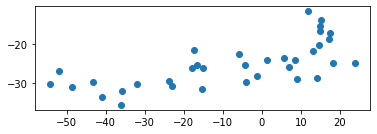

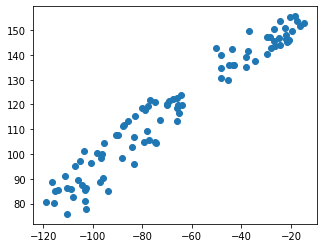

In [9]:
# Filter out uphill anchor trees with min_anchor_diameter < 40
min_anchor_diameter = 30
anchor_trees_gdf_filtered_diameter = anchor_trees_gdf[anchor_trees_gdf["BHD"]>str(min_anchor_diameter)]
anchor_trees_gdf_filtered_diameter.plot()

# And filter the target trees
target_trees_gdf_filtered_diameter = target_trees_gdf[target_trees_gdf["BHD"]>str(min_anchor_diameter)]
target_trees_gdf_filtered_diameter.plot()

##### Generating the possible lines depending on the slope

we have n lines:  178


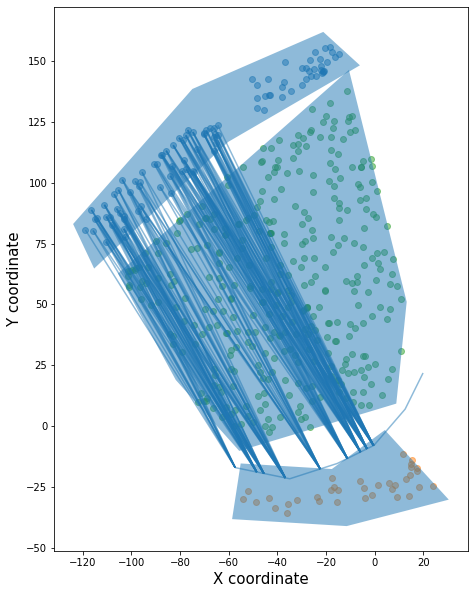

In [10]:
import geometry_utilities
reload(geometry_operations)
reload(geometry_utilities)

max_main_line_slope_deviation = 5
max_anchor_distance = 20
possible_lines, slope_deviation, possible_anchor_triples = geometry_operations.generate_possible_lines(road_points, target_trees_gdf_filtered_diameter, anchor_trees_gdf_filtered_diameter, slope_line, max_main_line_slope_deviation, max_anchor_distance)
print("we have n lines: ",len(possible_lines))

line_gdf = gpd.GeoDataFrame(geometry=possible_lines)

#add the length of each line
line_gdf["line_length"] = line_gdf.geometry.length
line_gdf["slope_deviation"] = slope_deviation
line_gdf["possible_anchor_triples"] = possible_anchor_triples

plotting.plot_gdfs([target_trees_gdf_filtered_diameter,anchor_trees_gdf_filtered_diameter, inner_forest_gdf, extra_geometry_gpd,line_gdf])

<AxesSubplot:>

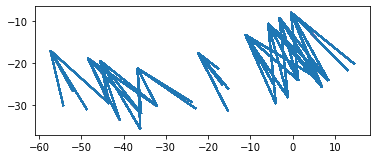

In [11]:
# very ugly list decomprehension
sublist = [item for sublist in line_gdf["possible_anchor_triples"] for item in sublist]
b = [item for subliste in sublist for item in subliste]
c = gpd.GeoSeries(b)
c.plot()

#### Optimization Setup

In [12]:
# Apply the Line Cost Function:
line_gdf["line_cost"] = optimization_functions.line_cost_function(line_gdf["line_length"],line_gdf["slope_deviation"])

# Create a matrix with the distance between every tree and line
cost_matrix = geometry_operations.compute_distances_facilities_clients(harvesteable_trees_gdf, line_gdf)

# sort the facility (=lines) and demand points (=trees)
facility_points_gdf = line_gdf.reset_index()
demand_points_gdf = harvesteable_trees_gdf.reset_index()

#### SpOPT

Creating our custom problem with constraints

- Obj Func v4:
	- ```sum(lscp.aij[cli][fac] * cli_assgn_vars[cli][fac])```
		- minimize the overall distance between clients and the factory they are assigned too
	- ```sum(fac_vars[fac]*fac_cost[fac] for fac in facility_range])```
		- minimize the sum of factory costs

- Matrices:
	- Lineactiveindex = fac_vars = $[l1+l2...]$
	- linetreeactiveindex = cli_assgn_vars = $[[l1*cli1+l1*cli2...],[l2*cli1+l2*cli2+....]]$

	- fac_cost: the cost of each line
	- cli_demand: mocked variable as of now, can be changed to reflect profit of given tree

- Constraints:
	- Constraint 1:
		- Each client is only assigned to one factory: ```pulp.lpSum([cli_assgn_vars[cli][fac] for fac in facility_range]) == 1```

	- Constraint 2: 
		- Every factory that has a client assigned must be opened: ```lscp.problem += fac_vars[fac] - cli_assgn_vars[cli][fac] >= 0```



In [273]:
solver = pulp.PULP_CBC_CMD(msg=False, warmStart=True)
name = "model"

# create the nr of possible facilities and clients 
client_range = range(cost_matrix.shape[0])
facility_range = range(cost_matrix.shape[1])

# add facility cost
facility_cost = line_gdf.line_cost*20
# and set the BHD as "weight" of the tree for now - substitute this via better computation
client_demand = harvesteable_trees_gdf.BHD

# create the aij cost matrix
weights = np.reshape(client_demand.replace(',', '.', regex=True).astype(float).values, (cost_matrix.shape[0], 1))
aij = cost_matrix * weights

# init the model with name and the problem - this only gives it a name and tells it to minimize the obj function
problem = pulp.LpProblem(name, pulp.LpMinimize)
model = PMedian(name, problem, aij)

# Add the facilities as fac_vars and facility_clients as cli_assgn_vars
optimization_functions.add_facility_variables(model, facility_range)
optimization_functions.add_facility_client_variables(model, facility_range, client_range)

# Add the objective functions
optimization_functions.add_moo_objective_function(model, facility_range, client_range, facility_cost)

# Assignment/demand constraint - each client should only be assigned to one factory
optimization_functions.add_singular_assignment_constraint(model, facility_range, client_range)

# Add opening/shipping constraint - each factory that has a client assigned to it should also be opened
optimization_functions.add_facility_is_opened_constraint(model, facility_range, client_range)

model = model.solve(solver)

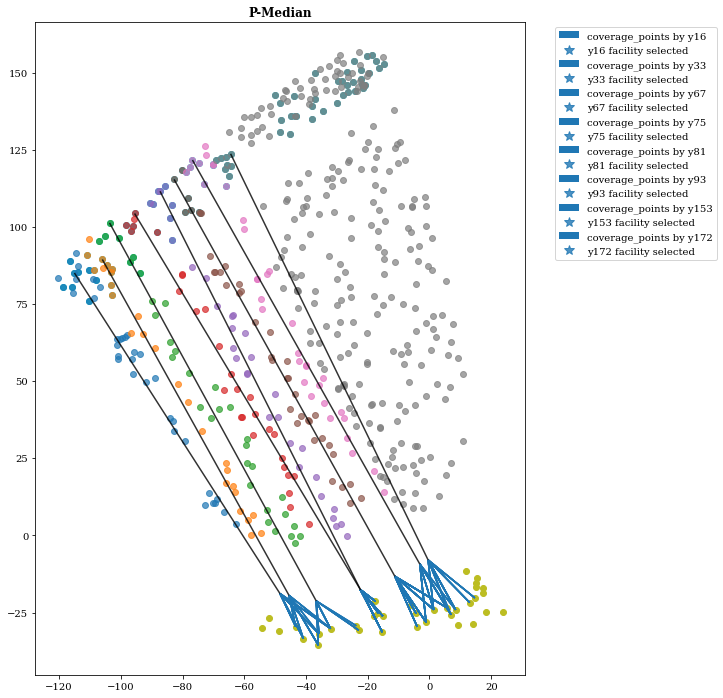

In [274]:
reload(plotting)
plotting.plot_p_median_results(model, facility_points_gdf, demand_points_gdf, anchor_trees_gdf_filtered_diameter, target_trees_gdf_filtered_diameter, line_gdf)

In [254]:
# import matplotlib.pyplot
import matplotlib.pyplot as plt 

# import pandas and numpy for being able to store data in DataFrame format
import numpy as np
import pandas as pd

# define step-size
stepSize = 1

# initialize empty DataFrame for storing optimization outcomes
solutionTable = pd.DataFrame(columns=["alpha","x1_opt","x2_opt","obj_value"])

# iterate through alpha values from 0 to 1 with stepSize, and write PuLP solutions into solutionTable
for i in range(0,10,1):
        # # declare the problem again
        # linearProblem = PuLP.LpProblem("Multi-objective linear maximization",PuLP.LpMaximize)
        # # add the objective function at sampled alpha
        # linearProblem += (i/100)*(2*x1+3*x2)+(1-i/100)*(4*x1-2*x2)
        # # add the constraints
        # linearProblem += x1 + x2 <= 10
        # linearProblem += 2*x1 + x2 <= 15
        # # solve the problem 
        # solution = linearProblem.solve()

        problem = pulp.LpProblem(name, pulp.LpMinimize)
        model = PMedian(name, problem, aij)

        # Add the facilities as fac_vars and facility_clients as cli_assgn_vars
        optimization_functions.add_facility_variables(model, facility_range)
        optimization_functions.add_facility_client_variables(model, facility_range, client_range)

        # Add the objective functions
        optimization_functions.add_moo_objective_function(model, facility_range, client_range, facility_cost)

        # Assignment/demand constraint - each client should only be assigned to one factory
        optimization_functions.add_singular_assignment_constraint(model, facility_range, client_range)

        # Add opening/shipping constraint - each factory that has a client assigned to it should also be opened
        optimization_functions.add_facility_is_opened_constraint(model, facility_range, client_range)

        model = model.solve(solver)
        # write solutions into DataFrame
        solutionTable.loc[int(i/(stepSize*100))] = [i/100,
                                                #      pulp.value(x1),
                                                #      pulp.value(x2),
                                                     pulp.value(problem.objective)]

# visualize optimization outcome, using matplotlib.pyplot
# -- set figure size
plt.figure(figsize=(20,10))
# -- create line plot
plt.plot(solutionTable["alpha"],solutionTable["obj_value"],color="red")
# -- add axis labels
plt.xlabel("alpha",size=20)
plt.ylabel("obj_value",size=20)
# -- add plot title
plt.title("Optimal combined objective function value as a function of alpha",size=32)
# -- show plot
plt.show()

TypeError: 'int' object is not iterable

In [379]:
from random import randint
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.unsga3 import UNSGA3
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.mutation.inversion import InversionMutation
from pymoo.operators.sampling.rnd import BinaryRandomSampling, IntegerRandomSampling, PermutationRandomSampling
from pymoo.termination import get_termination
from pymoo.operators.crossover.pntx import TwoPointCrossover

class SupportLinesProblem(ElementwiseProblem):
    def __init__(self, cost_matrix, line_cost, **kwargs):
        
        self.cost_matrix = cost_matrix
        # create the nr of possible facilities and clients 
        self.client_range = cost_matrix.shape[0]
        self.facility_range = cost_matrix.shape[1]

        # add facility cost
        self.facility_cost = np.array(line_cost)
        
        # = (n_trees*n_facs+n_facs)+n_facs
        self.n_var = self.client_range*self.facility_range+self.facility_range
        
        super().__init__(n_var=self.n_var, n_obj=2, n_ieq_constr=self.client_range*2, xl=0, xu=1, vtype=int, **kwargs)

    def _evaluate(self, x, out, *args, **kwargs):
        # reshape n_var to (n_trees*n_facs+n_facs)
        variable_matrix = x.reshape((self.client_range+1,self.facility_range))
        cli_assgn_vars = variable_matrix[:-1]
        fac_vars = variable_matrix[-1]

        overall_distance_obj = np.sum(cli_assgn_vars*self.cost_matrix)
        overall_cost_obj = np.sum(fac_vars*self.facility_cost)

        # for each row sum should be 1 -> only one client allowed
        singular_assignment_constr = - np.sum(cli_assgn_vars,axis=1)

        # want to enforce that for each row where a 1 exists, fac_vars also has a 1
        #-> happens when a * b each entry is > 0
        # now we maximize this -> for each row, the value has to be >= 1
        # we have: sum(row)
        facility_is_opened_constr = - np.dot(cli_assgn_vars.astype(int),fac_vars.astype(int)) + 1 
        #facility_is_opened_constr = np.dot(cli_assgn_vars.astype(int),fac_vars.astype(int)) - 1 

        print(overall_cost_obj)
        print(overall_distance_obj)
        out["F"] = np.column_stack([overall_distance_obj, overall_cost_obj])
        # ieq constr
        out["G"] = np.column_stack([facility_is_opened_constr,singular_assignment_constr])

import numpy as np
from pymoo.optimize import minimize

line_cost = line_gdf.line_cost*200

# create the aij cost matrix
client_demand = harvesteable_trees_gdf.BHD
weights = np.reshape(client_demand.replace(',', '.', regex=True).astype(float).values, (cost_matrix.shape[0], 1))
aij = cost_matrix * weights

problem = SupportLinesProblem(cost_matrix, line_cost)

termination = get_termination("n_gen", 300)

algorithm = NSGA2(
    pop_size=10,
    sampling=IntegerRandomSampling(),
    mutation=InversionMutation(),
    eliminate_duplicates=True
)

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               verbose=True)

X = res.X
F = res.F

2678797.2816288034
1782098.946801237
2357580.955562559
1794468.5688357367
2302088.8770671748
1782075.19623705
2642212.4012204846
1768628.5502962028
2675572.8938987786
1785817.1308955774
2461384.737647622
1778524.1663751553
2910812.394510491
1771284.66465114
2582850.0497993045
1785053.2981501753
2384843.256414485
1773340.0401830568
2314748.1981627415
1795539.20318471
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       10 |      3 |  0.000000E+00 |  0.000000E+00 |             - |             -
2086131.5153998374
1339936.4681327546
1673453.46568454
1329153.9936794308
1775005.8470804044
1339985.5125598074
2046917.598157173
1338953.4408734331
1698011.1245324835
1335025.1375621648
1831719.0473092035
1342704.9901558417
1450467.7477917392
1345337.265628836
1935232.7310530012
1333186.0693797912
1917165.3593814184
1345624.3737369594
1822504.5104965114
1330821.9935824785
     2 |       20 |      2 |  0.000000E+00 |  0.000000E+00 |  2.715610E+0

In [378]:
variable_matrix = X[0].reshape((len(demand_points_gdf)+1,len(line_gdf)))

cli_assgn_vars = variable_matrix[:-1]
fac_vars = variable_matrix[-1:][0]
#fac_vars
print(sum(cli_assgn_vars))
print(sum(fac_vars))

[70 60 51 74 62 49 55 69 56 72 64 81 56 64 50 58 64 64 48 58 62 66 69 70
 83 60 57 60 58 61 69 66 62 57 68 68 62 56 58 57 55 80 63 69 61 64 54 59
 61 66 76 60 64 56 54 65 51 55 52 63 54 68 57 57 63 63 79 55 62 66 57 65
 62 54 77 52 51 60 58 64 52 68 58 76 54 75 57 58 58 54 65 60 62 57 64 58
 53 58 67 80 62 70 60 65 65 56 59 59 62 68 53 71 67 71 49 51 59 73 59 61
 58 54 60 63 87 47 61 52 70 63 64 78 56 76 61 61 66 51 56 55 63 52 68 62
 67 59 49 63 57 65 56 56 63 52 50 58 61 72 61 68 69 62 69 65 54 64 64 70
 67 63 54 76 61 72 45 55 60 62]
45


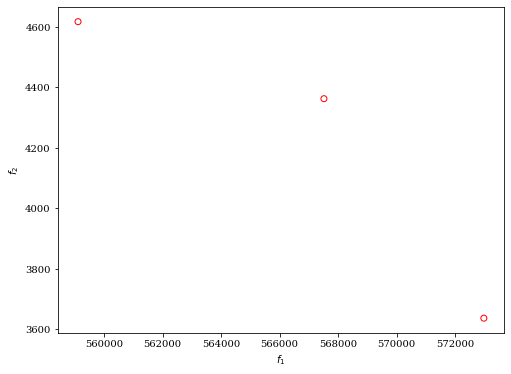

In [364]:
from pymoo.visualization.scatter import Scatter
plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()

In [ ]:
client_range = cost_matrix.shape[0]
facility_range = cost_matrix.shape[1]
variable_matrix = X[0].reshape((client_range+1,facility_range))
cli_assgn_vars = variable_matrix[:-1]
fac_vars = variable_matrix[-1:]

reload(plotting)
plotting.plot_pymoo_results(X, facility_points_gdf, demand_points_gdf, anchor_trees_gdf_filtered_diameter, target_trees_gdf_filtered_diameter)